Reconstructing kinematics
=========================

.. warning:: This tutorial refer to functions that are still experimental and that may change behaviour and signature.

In [1]:
import kineticstoolkit.lab as ktk
import numpy as np

### Defining rigid body configurations using a static acquisition ###

One of the aims of the static trial is to have a sample where every marker is visible. We use this trial to define the rigid body configuration. A rigid body configuration is a list of markers that form a rigid body, along with their local position in the rigid body's reference frame.

For this example, we will create rigid bodies for the markers triads 'ArmR' and 'ForearmR'.

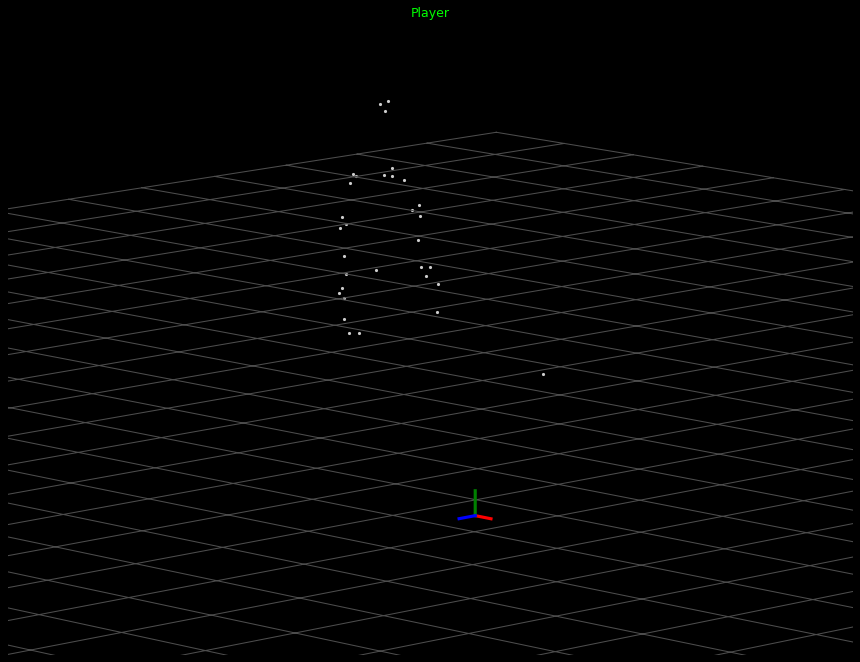

In [2]:
# Names of the markers
labels = [
    'Probe1', 'Probe2', 'Probe3', 'Probe4', 'Probe5', 'Probe6',
    'WheelchairRearR', 'WheelchairRearL', 'WheelchairFront',
    'ScapulaL1', 'ScapulaL2', 'ScapulaL3',
    'ScapulaR1', 'ScapulaR2', 'ScapulaR3',
    'Head1', 'Head2', 'Head3',
    'Sternum',
    'ArmL1', 'ArmL2', 'ArmL3',
    'LateralEpicondyleL', 'ForearmL1', 'ForearmL2', 'ForearmL3',
    'NAG',
    'GloveL1', 'GloveL2', 'GloveL3',
    'ArmR1', 'ArmR2', 'ArmR3',
    'LateralEpicondyleR', 'ForearmR1', 'ForearmR2', 'ForearmR3',
    'NAR',
    'GloveR1', 'GloveR2', 'GloveR3']

config = dict()                 # Will contain all configuration data.
config['RigidBodies'] = dict()  # Will contain all rigid body configurations.

# Read the static trial
markers = ktk.kinematics.read_n3d_file(
    ktk.config.root_folder + '/data/kinematics/sample_static.n3d',
    labels=labels)

# Show this trial, just to inspect it
player = ktk.Player(markers, zoom=2, azimuth=0.8, elevation=0.16,
           translation=(0.2, -0.7))

In [3]:
# Create the rigid body configurations
config['RigidBodies']['ArmR'] = ktk.kinematics.create_rigid_body_config(
        markers, ['ArmR1', 'ArmR2', 'ArmR3'])

config['RigidBodies']['ForearmR'] = ktk.kinematics.create_rigid_body_config(
        markers, ['ForearmR1', 'ForearmR2', 'ForearmR3'])

The probe's rigid body configuration is created manually from its specifications. Each local point is expressed relative to a reference frame that is centered at the probe's tip.

In [4]:
config['RigidBodies']['Probe'] = {
        'MarkerNames': ['Probe1', 'Probe2', 'Probe3',
                        'Probe4', 'Probe5', 'Probe6'],
        'LocalPoints': np.array([[
                [2.1213,   2.1213,  2.0575,   2.1213,   1.7070,   1.7762],
                [-15.8328, 15.8508, 16.0096,  16.1204,  -15.5780, -15.6057],
                [86.4285,  86.4285, 130.9445, 175.4395, 175.3805, 130.8888],
                [1000,     1000,    1000,     1000,     1000,     1000]]]
                ) / 1000
        }

### Defining the virtual marker configurations based on probing acquisitions ###

In [5]:
config['VirtualMarkers'] = dict()  # Will contain all virtual marker configurations

Since this is a repetitive operation, we will create a new function that will be called for each virtual marker:

In [6]:
def process_probing_acquisition(file_name, rigid_body_name):

    # Load the markers
    markers = ktk.kinematics.read_n3d_file(file_name, labels=labels)

    # Calculate rigid body trajectories using these markers
    rigid_bodies = ktk.kinematics.register_markers(markers,
                                                   config['RigidBodies'])

    # Add the marker 'ProbeTip' in markers. This is the origin of the Probe
    # rigid body.
    markers.data['ProbeTip'] = rigid_bodies.data['Probe'][:, :, 3]
    markers.add_data_info('ProbeTip', 'Color', 'r')

    # Create the marker configuration
    return ktk.kinematics.create_virtual_marker_config(
            markers, rigid_bodies, 'ProbeTip', rigid_body_name)

Now, we can process every probing acquisition.

In [7]:
config['VirtualMarkers']['AcromionR'] = process_probing_acquisition(
    ktk.config.root_folder +
    '/data/kinematics/sample_probing_acromion_R.n3d', 'ArmR')

config['VirtualMarkers']['MedialEpicondyleR'] = process_probing_acquisition(
    ktk.config.root_folder +
    '/data/kinematics/sample_probing_medial_epicondyle_R.n3d', 'ArmR')

config['VirtualMarkers']['OlecraneR'] = process_probing_acquisition(
    ktk.config.root_folder + 
    '/data/kinematics/sample_probing_olecrane_R.n3d', 'ForearmR')

config['VirtualMarkers']['RadialStyloidR'] = process_probing_acquisition(
    ktk.config.root_folder + 
    '/data/kinematics/sample_probing_radial_styloid_R.n3d', 'ForearmR')

config['VirtualMarkers']['UlnarStyloidR'] = process_probing_acquisition(
    ktk.config.root_folder + 
    '/data/kinematics/sample_probing_ulnar_styloid_R.n3d', 'ForearmR')

#### Defining segment configurations ####

This step is purely for visualization. Here, we define different segments
that will be shown in the Player.

In [8]:
config['Segments'] = dict()  # Will contain all segment definitions

config['Segments']['ArmR'] = {
        'Color': [1, 0.25, 0],
        'Links': [['AcromionR', 'MedialEpicondyleR'],
                  ['AcromionR', 'LateralEpicondyleR'],
                  ['AcromionR', 'OlecraneR']]
        }

config['Segments']['ForearmR'] = {
        'Color': [1, 0.5, 0],
        'Links': [['MedialEpicondyleR', 'RadialStyloidR'],
                  ['MedialEpicondyleR', 'UlnarStyloidR'],
                  ['LateralEpicondyleR', 'RadialStyloidR'],
                  ['LateralEpicondyleR', 'UlnarStyloidR'],
                  ['OlecraneR', 'RadialStyloidR'],
                  ['OlecraneR', 'UlnarStyloidR'],
                  ['UlnarStyloidR', 'RadialStyloidR']]
        }

Processing an experimental trial
--------------------------------

Now that we configured the rigid bodies and the virtual markers, we are ready to load an experimental trial, calculate the rigid body trajectories and recreate the virtual markers using these rigid bodies.

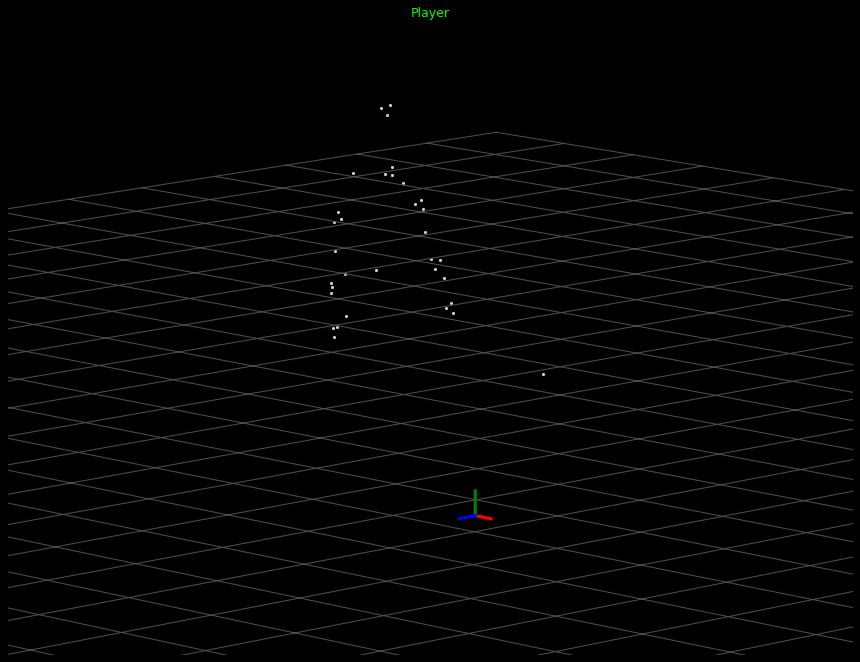

In [9]:
# Load the markers of the experimental trial
markers = ktk.kinematics.read_n3d_file(
    ktk.config.root_folder + '/data/kinematics/sample_propulsion.n3d',
    labels=labels)

# Show those markers in a player
player = ktk.Player(markers, zoom=2, azimuth=0.8, elevation=0.16,
           translation=(0.2, -0.7))

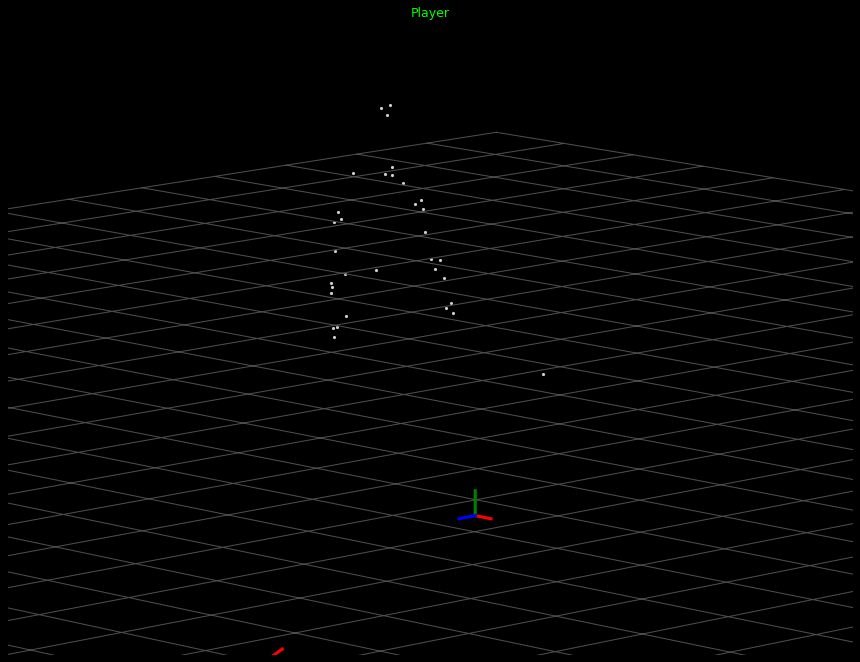

In [10]:
# Compute the rigid body trajectories
rigid_bodies = ktk.kinematics.register_markers(markers, config['RigidBodies'])

# Show those rigid bodies and markers in a player
player = ktk.Player(markers, rigid_bodies,
           zoom=2, azimuth=0.8, elevation=0.16, translation=(0.2, -0.7))

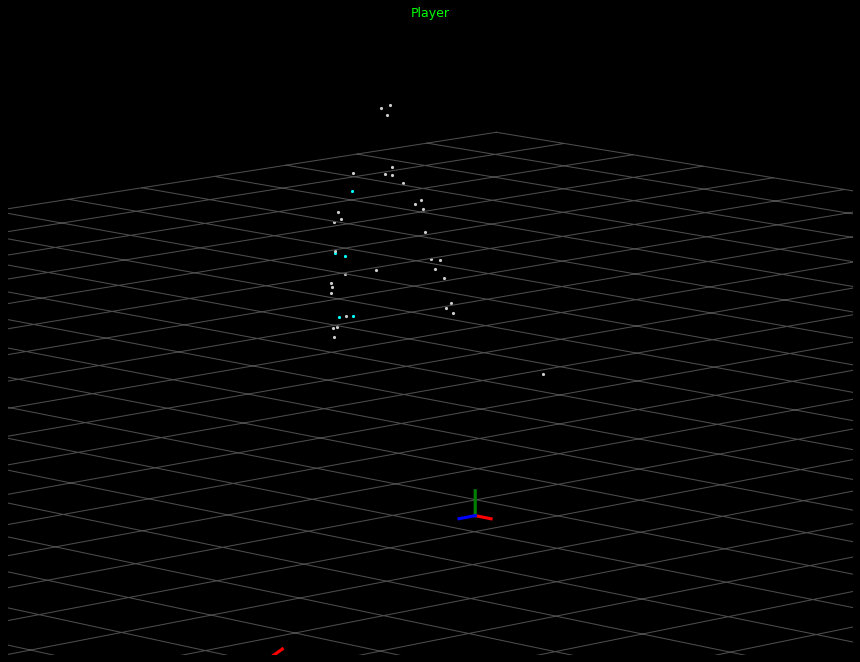

In [11]:
# Add the virtual markers

for virtual_marker in config['VirtualMarkers']:
    local_coordinates = config['VirtualMarkers'][virtual_marker]['LocalPoint']
    rigid_body_name = config['VirtualMarkers'][virtual_marker]['RigidBodyName']
    reference_frame = rigid_bodies.data[rigid_body_name]

    markers.data[virtual_marker] = ktk.geometry.get_global_coordinates(
            local_coordinates, reference_frame)

    # Assign a color for these virtual markers
    markers.add_data_info(virtual_marker, 'Color', 'c')

# Show the markers and rigid bodies in a player
player = ktk.Player(markers, rigid_bodies,
                    zoom=2, azimuth=0.8, elevation=0.16, translation=(0.2, -0.7))

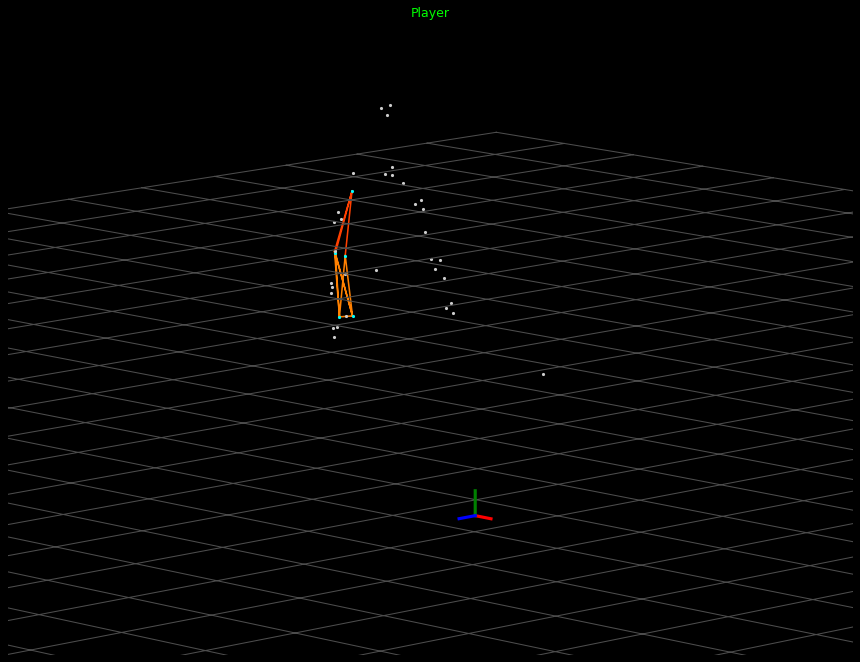

In [12]:
# Add the segments
player = ktk.Player(markers,
                    segments=config['Segments'], zoom=2, azimuth=0.8, elevation=0.16,
                    translation=(0.2, -0.7))

For more information on kinematics, please check the [API Reference for the kinematics module](../api/kineticstoolkit.kinematics.rst).